In [1]:
"""
# File to plot the (projected) size of the catalogue over the next 20 years
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table, vstack
import astropy.units as u
from astropy import constants as const
import pandas as pd


######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize



# First log all the observed GW events

Data was queried from [the GW-openscience portal](https://www.gw-openscience.org/eventapi/)
where we used 'GWTC-1-confident', 'GWTC-2.1-confident' and 'GWTC-3-confident'


In [5]:
# Combine the three catalogues
GWTC1 = Table.read('data/GWTC1_confident.csv', delimiter=',')
GWTC2 = Table.read('data/GWTC2_1_confident.csv', delimiter=',')
GWTC3 = Table.read('data/GWTC3_confident.csv', delimiter=',')
GWTC_all = vstack([GWTC1, GWTC2, GWTC3])

GWTC_all['obs_date_yr'] = np.full(len(GWTC_all), 0.)

# Assign flavours to the mergers
GWTC_all['flavour'] = np.full(len(GWTC_all), 'BHBH')
BHNS_names = ['GW190917_114630', 'GW191219_163120', 'GW200115_042309', 'GW200210_092254'] #GW190814 = sketch
NSNS_names = ['GW170817','GW190425']

# Correct the flavours and add the date
for i, name in enumerate(GWTC_all['commonName']):
    
    if name in BHNS_names:
        GWTC_all['flavour'][i] = 'BHNS'
    if name in NSNS_names:
        GWTC_all['flavour'][i] = 'NSNS'
        
    # change name to date
    year  = float(GWTC_all['commonName'][i][2:4])
    month = float(GWTC_all['commonName'][i][4:6])
    day   = float(GWTC_all['commonName'][i][6:8])
    GWTC_all['obs_date_yr'][i] = 2000 + year + (month-1)/12. + day/365.25 

        
print( len(GWTC_all[GWTC_all['flavour'] == 'NSNS']))
print(len(GWTC_all[GWTC_all['flavour'] == 'BHNS']))
print(len(GWTC_all[GWTC_all['flavour'] == 'BHBH']))

# print(GWTC_all.info())

##############################
# Add public O4a data from GraceDB
from ligo.gracedb.rest import GraceDb

# Create a GraceDb client
client = GraceDb()

# Fetch public events (the text indicates the query, space-separated works as an AND)
events = client.superevents('public O4 far < 1e-9') 

for event in events:
    year = int(event['superevent_id'][1:2])
    month = int(event['superevent_id'][3:4])
    day = int(event['superevent_id'][5:6])
    obs_date_yr = 2000 + year + (month-1)/12. + day/365.25 
    
    if obs_date_yr > 2023.33:  # April 2023 corresponds to O4a
        print('obs_date_yr',obs_date_yr)
        # Create a new row (there are only BBHs in O4a, so Im not checking the flavour column here)
        new_row = {
            'obs_date_yr': obs_date_yr,
            'flavour': 'BHBH',
            'commonName': event['superevent_id'],
            'far': event['far']
        }
        # Append the new row to the GWTC_all Table
        GWTC_all.add_row(new_row)


print(GWTC_all.info())

# Manually log the end dates of the Observing runs:
end_O1 = 2016 + (1-1)/12. +19./365.25 # 19 January 2016
end_O2 = 2017 + (8-1)/12. +25./365.25 # 25 August 2017
end_O3 = 2020 + (3-1)/12. +27./365.25 # 27 March 2020
end_O4a = 2024 + (1-1)/12. + 17/365.25 # 17 Jan 2024 

# 
print(GWTC_all['obs_date_yr'].min(), GWTC_all['obs_date_yr'].max())


2
4
84
<Table length=90>
              name                dtype     class     n_bad
-------------------------------- ------- ------------ -----
                              id   str18       Column     0
                      commonName   str15       Column     0
                         version   int64       Column     0
               catalog.shortName   str18       Column     0
                             GPS float64       Column     0
                       reference   str33       Column     0
                         jsonurl   str82       Column     0
                   mass_1_source float64       Column     0
             mass_1_source_lower float64       Column     0
             mass_1_source_upper float64       Column     0
                   mass_2_source float64       Column     0
             mass_2_source_lower float64       Column     0
             mass_2_source_upper float64       Column     0
      network_matched_filter_snr float64       Column     0
network_matched

# Upcoming gravitational wave detectors

|     Name                 |     Dates                                                           |     DR dates                                                                                              |     frequency            |     Citation                                                                                                                                        |
|--------------------------|---------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------|--------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------|
|     O4                   |     May 2023 – Dec 2024                                             |     O4a = oct 2025. (DR = 18 months   after end of 6 month obs block)     O4b = may 2026                  |     10 Hz to 10 kHz      |     https://observing.docs.ligo.org/plan/                                                                                                           |
|     O5                   |     2027 - 2030                                                     |     O5a = ? jan2029 ?     O5b = ? June 2032?                                                              |     10 Hz to 10 kHz      |     https://observing.docs.ligo.org/plan/                                                                                                           |
|     Voyager              |     2028–2038.      (10   years continuous operation)               |                                                                                                           |     10 – 10 kHz ?        |     https://ui.adsabs.harvard.edu/abs/2020CQGra..37p5003A/abstract     https://dcc.ligo.org/public/0113/T1400316/004/T1400316-v5.pdf                |
|     DECIGO               |     2030-ies                                                        |                                                                                                           |     10^-3 - 100 Hz       |     https://ui.adsabs.harvard.edu/abs/2006CQGra..23S.125K/abstract                                                                                  |
|     LISA                 |     2037 – 2041 or 2047      4 year   mission + 6 year extension    |     Athena-LISA synnergy                                                                                  |     1e-5 – 1 Hz          |     https://ui.adsabs.harvard.edu/abs/2019CQGra..36j5011R/abstract                                                                                  |
|     TianQin              |     2030-ies                                                        |                                                                                                           |     10^-4 - 10^-1 Hz     |     https://ui.adsabs.harvard.edu/abs/2016CQGra..33c5010L/abstract                                                                                  |
|     Big Bang Observer    |     (2025??)      Post   LISA                                       |     (fills gap between ligo and lisa)                                                                     |     0.1 – 1 Hz           |     https://ui.adsabs.harvard.edu/abs/2006CQGra..23.2435C/abstract                                                                                  |
|     ET                   |     2035                                                            |                                                                                                           |     1 to 10 kHz          |     https://ui.adsabs.harvard.edu/abs/2020JCAP...03..050M/abstract                                                                                  |
|     CE                   |     Later half of 2030-ies                                          |                                                                                                           |     5 Hz to 3.75 kHz?    |     https://arxiv.org/abs/1907.04833                                                                                                                |
|     PTA                  |     e.g. SKA                                                        |     SKA first light 2027            International   Pulsar Timing Array   = (PPTA, EPTA, and NANOGrav)    |     10^-9 - 10^-6 Hz     |     https://ui.adsabs.harvard.edu/abs/2015CQGra..32a5014M/abstract           https://ui.adsabs.harvard.edu/abs/2019PhRvD.100j4028H/abstract         |




***


In [49]:
# Use pandas to read excel file
df = pd.read_excel('data/FutureDetectors.xlsx', header =0, 
                   sheet_name = 'Gravitational wave observations')
# pour it into Astropy table
GW_missions = Table.from_pandas(df)

#######################
# Manually add GW 04a and b
O4a =  GW_missions[GW_missions['Name'] == 'O4'].copy()
O4a['Name'] = 'O4a'
O4a['mission_end_year']  = 2024
O4a['mission_end_month'] = 1

O4b =  GW_missions[GW_missions['Name'] == 'O4'].copy()
O4b['Name'] = 'O4b'
O4b['mission_start_year']  = 2024
O4b['mission_start_month'] = 11
O4b['mission_end_year']  = 2025
O4b['mission_end_month'] = 6

GW_missions = vstack([GW_missions, O4a, O4b])

# Add some extra columns
GW_missions['mission_start']   = GW_missions['mission_start_year'] + (GW_missions['mission_start_month']-1)/12.
GW_missions['mission_end']     = GW_missions['mission_end_year'] + (GW_missions['mission_end_month']-1)/12.
GW_missions['mid_mission']     = (GW_missions['mission_start'] + GW_missions['mission_end'])/2.
GW_missions['freq_center'] = (GW_missions['freq_end']  + GW_missions['freq_start'])/2.


display(GW_missions)

# Add SKA-era PTAs “Square-Kilometre-Array” (SKA) (e.g. Terzian & Lazio 2006).
#     Phase 1: Providing ~10% of the total collecting area at low and mid frequencies by 2023 (SKA1).[29]
#     Phase 2: Completion of the full array (SKA2) at low and mid frequencies by 2030.[30]
# 70 Months From July 01, 2021  = May 01, 2027 
# souce https://www.skao.int/en/science-users/159/scientific-timeline
SKADR = Table()

SKADR['name']  = ['SKA2']#'SKA1', 
SKADR['year']  = [2029]#2021, 
SKADR['month'] = [5]#7,   
SKADR['date']  = SKADR['year'] + (SKADR['month']-1)/12.
SKADR['opt_freq']     = GW_missions['opt_freq'][GW_missions['Name'] == 'PTA'] 





Name,mission_start_year,mission_start_month,mission_end_year,mission_end_month,freq_start,freq_end,opt_freq,DR dates,Citation,Notes,mission_start,mission_end,mid_mission,freq_center
str7,int64,int64,int64,int64,float64,float64,float64,str84,str126,str61,float64,float64,float64,float64
O4,2023,5,2024,11,10.0,10000.0,200.0,"O4a = oct 2025. (DR = 18 months after end of 6 month obs block), O4b = may 2026",https://observing.docs.ligo.org/plan/,--,2023.3333333333333,2024.8333333333333,2024.0833333333333,5005.0
O5,2027,1,2029,6,10.0,10000.0,200.0,"O5a = ? jan2029 ?, O5b = ? June 2032?",https://observing.docs.ligo.org/plan/,--,2027.0,2029.4166666666667,2028.2083333333335,5005.0
Voyager,2030,1,2035,1,10.0,5000.0,40.0,--,"https://ui.adsabs.harvard.edu/abs/2020CQGra..37p5003A/abstract, https://dcc.ligo.org/public/0113/T1400316/004/T1400316-v5.pdf",10 years cont. operation,2030.0,2035.0,2032.5,2505.0
DECIGO,2037,1,2040,1,0.001,100.0,0.3,--,https://ui.adsabs.harvard.edu/abs/2006CQGra..23S.125K/abstract,"start = ""2030-ies""",2037.0,2040.0,2038.5,50.0005
LISA,2037,1,2041,1,1e-05,1.0,0.003,--,https://ui.adsabs.harvard.edu/abs/2019CQGra..36j5011R/abstract,4 year mission + 6 year extension (note Athena-LISA synnergy),2037.0,2041.0,2039.0,0.500005
TianQin,2037,1,2040,1,0.0001,1.0,0.1,--,https://ui.adsabs.harvard.edu/abs/2016CQGra..33c5010L/abstract,"start = ""2030-ies""",2037.0,2040.0,2038.5,0.50005
ET,2038,1,2045,1,1.0,10000.0,100.0,--,"https://ui.adsabs.harvard.edu/abs/2020JCAP...03..050M/abstract, https://www.et-gw.eu/",--,2038.0,2045.0,2041.5,5000.5
CE,2038,1,2045,1,5.0,3750.0,50.0,--,https://arxiv.org/abs/1907.04833,--,2038.0,2045.0,2041.5,1877.5
PTA,2020,1,2045,1,1e-09,1e-06,1e-08,"SKA first light 2027, International Pulsar Timing Array = (PPTA, EPTA, and NANOGrav)","https://ui.adsabs.harvard.edu/abs/2015CQGra..32a5014M/abstract ,https://ui.adsabs.harvard.edu/abs/2019PhRvD.100j4028H/abstract",--,2020.0,2045.0,2032.5,5.005e-07


# Detection rate 
To estimate the number of events for future observation runs, we need some yearly detection rate which we can  multiply by the mission length


## For O4 and O5
The Summary Statistics from Ligos 'Observing Capabilities' webpage: 
https://emfollow.docs.ligo.org/userguide/capabilities.html#datadrivenexpectations

quote the Sensitive volume ( = detection rate / merger rate)
and Merger rate for all three flavours (BBH, BHNS, NSNS) for O4 and O5, including 5% to 95% confidence intervals.

the detection rate = Sensitive volume * merger rate

## For Voyager, the Einstein telescope, and Cosmic explorer

both values below are for S/N > 10

The network name "VK+HLIv" corresponds to "three LIGO detectors (HLI) operating with Voyager technology in addition to A+ versions of Virgo and KAGRA."
The network name "ECS" corresponds to a network containing ET, CE-North, and CE-South.

#### BBH and NSNS
Table IV from  [Borhanian & Sathyaprakash 2022](https://arxiv.org/pdf/2202.11048.pdf) lists detection rate per year BBH and NSNS mergers  
They assume the following rates [NSNS, BHBH] = [4.7 * 10^5, 1.2 * 10^5] $yr^{-1}$


#### BHNS
Table IV. from [Gupta et al. 2023](https://ui.adsabs.harvard.edu/abs/2023arXiv230108763G/abstract)
list the detection rate for BHNS

They assume the following rates [NSBH] = [4*10^4] $yr^{-1}$  (up to z = 20)


Alternative: Tables 4, 5, and 3 [Iacovelli et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...941..208I/abstract) 
future_detections['ET_detection_rate'] = [40107, 29707, 69799] # N/yr


# Estimates of cosmic rate
from the [pop GWTC3 paper](https://arxiv.org/abs/2111.03634)
Using the _redshift independent rates_!

NSNS merger rate = $10 - 1700 \mathrm{Gpc^{−3}yr^{−1}}$ \
BHNS merger rate = $7.8 - 140 \mathrm{Gpc^{−3}yr^{−1}}$ \
BBH merger  rate = $16 – 61 \mathrm{Gpc^{−3}yr^{−1}}$ \
(at z=0.2, R_BBH = 17.9- 44)


Combining this with the 'volume' of the Universe up to z=20 we can use this to re-scale the detection rates from other works
E.g. 


In [50]:
# Use the LIGO rates to propagate the rate error to the detection rate

# First convert the GWTC3 rates to yr^-1
from astropy.cosmology import WMAP9 as cosmology
redshifts = 20
# convert redshifts to volumnes and ensure all volumes are in Gpc^3
volumes = cosmology.comoving_volume(redshifts).to(u.Gpc**3).value
print(volumes)

# LVK obs [min, max] Rates per year
NSNS_rates_yr = [10 *volumes, 1700*volumes]
BHNS_rates_yr = [7.8 *volumes, 140*volumes]
BHBH_rates_yr = [16 *volumes, 61*volumes]

print(NSNS_rates_yr, BHNS_rates_yr, BHBH_rates_yr)

# Detection_rate_scaled  =  (Rate_LIGO/Rate_paper) * Detection_rate_paper
NSNS_scale_fact = [NSNS_rates_yr[0]/(4.7*1e5), NSNS_rates_yr[1]/(4.7*1e5)] #rate from Borhanian & Sathyaprakash
BHNS_scale_fact = [BHNS_rates_yr[0]/(4e4), BHNS_rates_yr[1]/(4e4)] # Gupta
BHBH_scale_fact = [BHBH_rates_yr[0]/(1.2*1e5), BHBH_rates_yr[1]/(1.2*1e5)]#rate from Borhanian & Sathyaprakash


print(NSNS_scale_fact[1], BHNS_scale_fact[0])



5619.610618229717
[56196.10618229717, 9553338.05099052] [43832.962822191796, 786745.4865521603] [89913.76989167547, 342796.24771201273]
20.326251172320255 1.0958240705547948


In [51]:
future_detections = Table()

future_detections['flavour'] = ['NSNS', 'BHNS', 'BHBH']

# cosmic merger rates
future_detections['cosmic_merger_rate_min']  = [10,  7.8, 16 ] # Gpc^-3 yr^-1
future_detections['cosmic_merger_rate_max']  = [1700,140, 61 ] # Gpc^-3 yr^-1


# O4 
# the detection rate = Sensitive volume * merger rate
future_detections['O4_Sensitive_vol']  = [0.172, 0.78, 15.15] # N/yr
future_detections['O4_detection_rate_min'] = future_detections['O4_Sensitive_vol'] * future_detections['cosmic_merger_rate_min'] # N/yr
future_detections['O4_detection_rate_max'] = future_detections['O4_Sensitive_vol'] * future_detections['cosmic_merger_rate_max']  # N/yr

future_detections['O4_detection_rate'] = [0.172 * 210 ,0.78  * 8.6, 15.15 * 17.1] # N/yr

# O4 
# the detection rate = Sensitive volume * merger rate
future_detections['O5_Sensitive_vol'] = [0.827, 3.65 , 50.7]  # N/yr
future_detections['O5_detection_rate_min'] = future_detections['O5_Sensitive_vol'] * future_detections['cosmic_merger_rate_min'] # N/yr
future_detections['O5_detection_rate_max'] = future_detections['O5_Sensitive_vol'] * future_detections['cosmic_merger_rate_max']  # N/yr


future_detections['O5_detection_rate'] = [0.827 * 210, 3.65 * 8.6, 50.7 * 17.1]  # N/yr

# Voyager 
# table IV from [Borhanian & Sathyaprakash 2022], and Table IV. from [Gupta et al. 2023]
future_detections['Voyager_detection_rate'] = [1800, 5.7*1e3 ,31000] # N/yr

future_detections['Voyager_detection_rate_min'] = future_detections['Voyager_detection_rate'] * [NSNS_scale_fact[0], BHNS_scale_fact[0], BHBH_scale_fact[0]] # N/yr
future_detections['Voyager_detection_rate_max'] = future_detections['Voyager_detection_rate'] * [NSNS_scale_fact[1], BHNS_scale_fact[1], BHBH_scale_fact[1]] # N/yr


# ET/CE network (just using 'ET' to represent ECS network)
# BBH, NSNS: Borhanian & Sathyaprakash 2022, BHNS: Table IV. from [Gupta et al. 2023]
future_detections['ET_detection_rate'] = [2.7*1e5, 3.9*1e4, 1.2*1e5] # N/yr

future_detections['ET_detection_rate_min'] = future_detections['ET_detection_rate'] * [NSNS_scale_fact[0], BHNS_scale_fact[0], BHBH_scale_fact[0]] # N/yr
future_detections['ET_detection_rate_max'] = future_detections['ET_detection_rate'] * [NSNS_scale_fact[1], BHNS_scale_fact[1], BHBH_scale_fact[1]] # N/yr

# Iacovelli et al. 2022 Tables 4, 5, and 3
# future_detections['ET_detection_rate'] = [40107, 29707, 69799] # N/yr


display(future_detections)


flavour,cosmic_merger_rate_min,cosmic_merger_rate_max,O4_Sensitive_vol,O4_detection_rate_min,O4_detection_rate_max,O4_detection_rate,O5_Sensitive_vol,O5_detection_rate_min,O5_detection_rate_max,O5_detection_rate,Voyager_detection_rate,Voyager_detection_rate_min,Voyager_detection_rate_max,ET_detection_rate,ET_detection_rate_min,ET_detection_rate_max
str4,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
NSNS,10.0,1700,0.172,1.7199999999999998,292.4,36.12,0.827,8.27,1405.8999999999999,173.67,1800.0,215.2191300598615,36587.25211017646,270000.0,32282.869508979224,5488087.816526469
BHNS,7.8,140,0.78,6.084,109.2,6.708,3.65,28.47,511.0,31.389999999999997,5700.0,6246.1972021623305,112111.23183368285,39000.0,42737.138751636994,767076.8493883563
BHBH,16.0,61,15.15,242.4,924.15,259.06500000000005,50.7,811.2,3092.7000000000003,866.9700000000001,31000.0,23227.72388868283,88555.69732560328,120000.0,89913.76989167547,342796.24771201273


end_date 2016.0520191649555
end_date 2017.6517796030116
end_date 2020.2405886379192


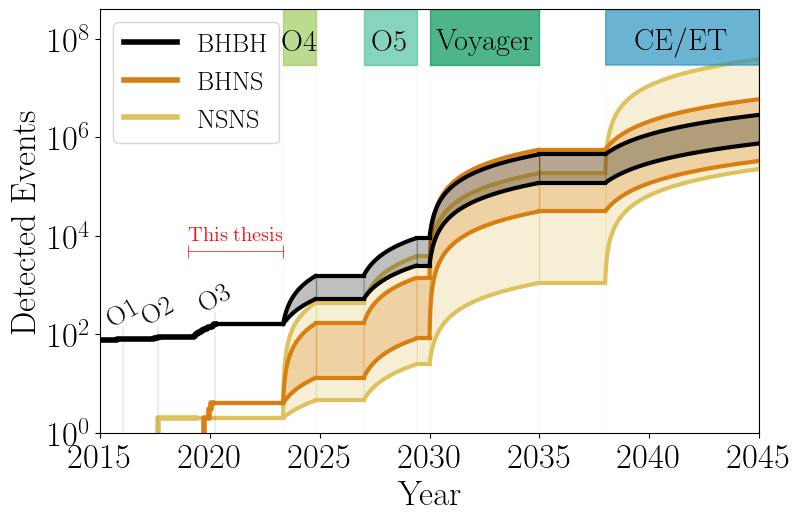

In [54]:
fig, ax = plt.subplots(figsize = (8.5,11/2.))

colors = ['black', '#d97f11', '#dec25d']
dt     = 0.01 # timestep in year
linewid= 3

GW_missions.sort('mission_start')


##########################
# Loop over the three flavours
for f, flavour in enumerate(['BHBH', 'BHNS', 'NSNS']):
#     if f == 0: 
#         continue
    ##########################
    # Past detections
    flav_tab = GWTC_all[GWTC_all['flavour'] == flavour]
    flav_tab.sort('obs_date_yr')
    
    # Duplicate first row 
    flav_tab = vstack([flav_tab[0], flav_tab])

    # N is also the cumsum
    detected_events = np.arange(len(flav_tab)) 

    # Plot cumulative sum of events
    plt.step(flav_tab['obs_date_yr'], detected_events,
             color = colors[f], lw = linewid+1, label = "$\mathrm{%s}$"%(flavour) )
    
    end_previous    = flav_tab['obs_date_yr'][-1]
    events_previous_min = detected_events[-1]
    events_previous_max = detected_events[-1]
    
    ##########################
    # Near Future detectors (just using ET to represent ECS network)
    for detector in ['O4', 'O5', 'Voyager', 'ET']: 
        detection_rate_min = future_detections[detector + '_detection_rate_min'][future_detections['flavour'] == flavour]
        detection_rate_max = future_detections[detector + '_detection_rate_max'][future_detections['flavour'] == flavour]
        
        # Use smooth time stepping for the observing period 
        period = np.arange(GW_missions['mission_start'][GW_missions['Name'] == detector][0], GW_missions['mission_end'][GW_missions['Name'] == detector][0] +dt, dt )
        time_steps  = np.full(len(period), dt) # an array filled with n times dt

        # Calculate the min number of detections (cumsum) during this run
        N_events_min   = detection_rate_min * time_steps
        N_events_min[0]= events_previous_min # start where you ended in the previous line
        new_events_min = np.cumsum(N_events_min)
        
        # Calculate the miax number of detections (cumsum) during this run
        N_events_max   = detection_rate_max * time_steps
        N_events_max[0]= events_previous_max # start where you ended in the previous line
        new_events_max = np.cumsum(N_events_max)
                
        # plot it
        plt.fill_between(period, y1 = new_events_min, y2 = new_events_max, zorder = 3-f, 
                         edgecolor = colors[f], color = colors[f], label = None, alpha = 0.25)
        
        plt.plot(period, new_events_min, color = colors[f], ls = '-',
                 lw = linewid, label = None, solid_capstyle='round',zorder = 3-f)
        plt.plot(period, new_events_max, color = colors[f], ls = '-',
                 lw = linewid, label = None, solid_capstyle='round',zorder = 3-f)
                

        ##########################
        # Connection piece        
        plt.fill_between((end_previous, period[0]), y1 = events_previous_min, y2 = events_previous_max, 
                         interpolate=True, zorder = 3-f, edgecolor = colors[f], lw = 0.0, color = colors[f], label = None, alpha = 0.25)
        
        plt.plot((end_previous, period[0]),(events_previous_min, events_previous_min), 
                 color = colors[f], lw = linewid, label = None,zorder = 3-f )
        plt.plot((end_previous, period[0]),(events_previous_max, events_previous_max),
                 color = colors[f], lw = linewid, label = None,zorder = 3-f )

        
        end_previous    = period[-1]#end[0]
        events_previous_min = new_events_min[-1]
        events_previous_max = new_events_max[-1]
        

##########################
# Label the past missions
for i, end_date in enumerate([end_O1, end_O2, end_O3]):
    print('end_date',end_date)
    BBH_tab = GWTC_all[GWTC_all['flavour'] == 'BHBH']
    N_det = len(BBH_tab[BBH_tab['obs_date_yr'] <=  end_date])
    plt.vlines(end_date, ymin=0, ymax = N_det *1.8, lw = 0.1, color = 'k')
    plt.text(end_date, N_det*1.8, '$\mathrm{O %s}$'%(i+1), 
             ha = 'center', fontsize = 20, rotation = 30 )
    
##########################
# Label the future missions
CEET_col = '#2c93bf'
space_col = '#029656'
voy_col = '#53C2A3'
O4a_col = '#9ecc5e'
O4b_col = '#9ecc5e'
O5_col = '#9ecc5e' #change
PTA_col = '#d1c54f'
mission_colors = [PTA_col, O4a_col, O4b_col, O5_col, voy_col, space_col,space_col,space_col, CEET_col, CEET_col]
#
for detector in ['O4', 'O5', 'Voyager', 'ET']: 
    mission = GW_missions[GW_missions['Name'] == detector]
    period = np.arange(mission['mission_start'][0], mission['mission_end'][0] + dt, dt )
    # There are more missions in the table than I show (this keeps color consistent)
    mis_i = np.where(GW_missions['Name'] == detector)[0][0]
    # Change the label name shown for ET/CE network
    if detector == 'ET':
        detector = 'CE/ET' 
        
    plt.text(GW_missions['mid_mission'][mis_i], 6e7, '$\mathrm{%s}$'%(detector), 
             ha = 'center', fontsize = 22 )
    plt.fill_between(period, y1 = 0, y2 = 3e7, edgecolor = 'k', facecolor = 'none',
                     alpha = 0.25, zorder = 0, lw = 0.1 )
    plt.fill_between(period, y1 = 3e7, y2 = 4e8, color = mission_colors[mis_i], alpha = 0.7)

##########################
# Label Thesis
thesis_start   = 1./365 + (1-1)/12. + 2019 
thesis_defense = 28./365 + (4-1)/12. + 2023 
plt.errorbar((thesis_start,thesis_defense), (5e3, 5e3), yerr = 0.3*5e3, lw = 0.5, color = 'r')
plt.text((thesis_defense+thesis_start)/2., 8e3, '$\mathrm{This \ thesis}$', 
     ha = 'center', fontsize = 15, rotation = 0,  c = 'r' )

##########################
# Plotvalues
plt.xlim(2015, 2045)
plt.ylim(1e0, 4e8)
plt.yscale('log')

plt.xlabel('$\mathrm{Year}$')
plt.ylabel('$\mathrm{Detected \ Events}$')
plt.legend(loc = 'upper left', fontsize = 19)
plt.savefig('SizeOfCatalogue_err.pdf', bbox_inches='tight', transparent=True)

plt.show()

